Goal: Take a sample from $x_1, ..., x_n$ proportional to weights $w_1, ..., w_n$ continuously. i.e. Not a multinomial smaple

Malik and Pitt resampling:

We are assuming that we have a set of uniforms that we use
to invert the cdf $\tilde{F}(x)$ above. So, we have the set of N, sorted in ascending order, uniform variates u1 < · · · < uN . The generation of the, possibly stratified, uniforms is discussed later in this appendix.


The pseudo-algorithm given below samples the index corre- sponding to the region which are stored as r1, r2, . . . , rN , and also produces a new set of uniforms, u∗1, . . . , u∗N 

set s = 0, j = 1; for {i = 0 : N}
{
    s = s + πi;
    while(uj ≤s & j≤N){
        rj =i;
        u∗j = (uj − (s − πi))/πi 
        j=j+1
}

For the selected regions where $r^j = 0$, we set $x_j^* = x^{(1)}$ and when $r^j = N$ we set $x_j^* = x^{(N)}$. Otherwise set: 
(x(rj+1) − x(rj)) × u∗j + x(rj
$x_j^* = (x^{(r^j+1)} - x^{(r^j)}) * u_j^* + x^{(r^j)}$

### Goal:

Sample $x_1,...,x_n$ from $f(x)$ with weights $\pi_j, j=1,...,n$

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import jax
from jax import random
import jax.numpy as jnp

In [18]:
"""
Make sure that the indices of samples and weights correspond to each other after sorting the sample, x
"""

np.random.seed(0)

N = 5
rv = norm()
x = rv.rvs(size=N)
print(x)

w = rv.pdf(x)
print(w)

[1.76405235 0.40015721 0.97873798 2.2408932  1.86755799]
[0.08417319 0.36824698 0.24711473 0.03239537 0.0697509 ]


In [36]:
x_dict = dict(zip(x, w))
print(x_dict.keys())

sorted_x_dict = dict(sorted(x_dict.items(), key = lambda x: x[0]))
sorted_x = np.array(list(sorted_x_dict.keys()))
sorted_weights = np.array(list(sorted_x_dict.values()))
sorted_x_dict

dict_keys([1.764052345967664, 0.4001572083672233, 0.9787379841057392, 2.240893199201458, 1.8675579901499675])


{0.4001572083672233: 0.36824697842193993,
 0.9787379841057392: 0.2471147305685094,
 1.764052345967664: 0.08417318529690802,
 1.8675579901499675: 0.06975089990562257,
 2.240893199201458: 0.032395372245369515}

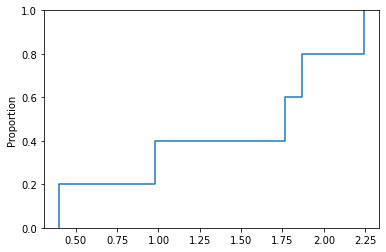

In [29]:
sns.ecdfplot(x);

In [221]:
def jax_cont_resample (weights, xs, key):
    n = len(weights)
    u_new = jnp.zeros(n)
    u0 = random.uniform(random.PRNGKey(key))
    u = (u0 + np.arange(n)) / n
    
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2
    
    def region_mid (k, val):
        xs = val["x"]
        r = val["r"]
        u_new = val["u_new"]
        return (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    
    def while_loop_func (val):
        u_j = val["u"][val["j"]]
        pi_i = val["pi"][val["i"]]
        
        val["r"] = val["r"].at[val["j"]].set(val["j"])
        val["u_new"] = val["u_new"].at[val["j"]].set((u_j - (val["s"] - pi_i)) / pi_i)
        
        # select region: 
        new_x = jax.lax.cond(
            val["r"][val["j"]] == 0,
            lambda _: val["x"][0],
            lambda _: jax.lax.cond(
                val["r"][val["j"]] == n,
                lambda _: val["x"][-1],
                lambda _: region_mid(val["j"], val),
                val
            ),
            val
        )
        val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
        val["j"] += 1
        return val 

    def while_cond (val):
        return jnp.logical_and(val["j"] < n, val["u"][val["j"]] <= val["s"])
    
    def for_loop_func (i, val):
        val["s"] += val["pi"][i]
        val["i"] = i
        val = jax.lax.while_loop(while_cond, while_loop_func, val)
        return val
 
    init_val = {
        "j": 0,
        "r": jnp.zeros(n, int),
        "s": 0,
        "i": 0,
        "u": u,
        "u_new": jnp.zeros(n),
        "x": xs,
        "x_new": jnp.zeros(n),
        "pi": pi}
    
    val = jax.lax.fori_loop(0, n, for_loop_func, init_val)

    # select region: 
    new_x = jax.lax.cond(
        val["r"][val["j"]] == 0,
        lambda _: val["x"][0],
        lambda _: jax.lax.cond(
            val["r"][val["j"]] == n,
            lambda _: val["x"][-1],
            lambda _: region_mid(val["j"], val),
            val
        ),
        val
    )
    val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
    
    return val["x_new"]

In [207]:
def continuous_stratified_resample(weights, xs):
    """
    Args: 
        - weights: normalized weights with indices corresponding to xs. This is represented by \pi in the paper
        - xs: samples sorted in ascending order. Represented by x^{(k)} in the paper. 
        
    TODO:
        - Make sure xs are sorted and weights correspond to them.
    """
    n = len(weights)
    # generate n uniform rvs with stratified method
    u0 = np.random.uniform(size=1)
#     u = [(u0 + i) / n for i in range(n)]
    u = (u0 + np.arange(n)) / n
#     print(u)
    
    # A.1: general form of continuous distribution
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2
    
#     for i in range(1, n):
#         pi[i] = (weights[i] + weights[i - 1]) / 2
        
    # A.3
    r = np.zeros(n)
    u_new = np.zeros(n)
    s = 0
    j = 1

    for i in range(n + 1):
        s = s + pi[i]
        while(j <= n and u[j - 1] <= s):
            r[j - 1] = i
            u_new[j - 1] = (u[j - 1] - (s - pi[i])) / pi[i]
            j = j + 1

    r = r.astype(int)

    x_new = np.zeros(n)
    for k in range(n):
        if r[k] == 0:
            x_new[k] = xs[0]
        elif r[k] == n:
            x_new[k] = xs[-1]
        else:
            x_new[k] = (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
#     print("r: ", r)
#     print("s: ", s)
#     print("u_new ", u_new)
#     print("x's: ", xs)
    return x_new


def continuous_stratified_resample2(weights, xs):
    """
    Args: 
        - weights: normalized weights with indices corresponding to xs. This is represented by \pi in the paper
        - xs: samples sorted in ascending order. Represented by x^{(k)} in the paper. 
        
    TODO:
        - Make sure xs are sorted and weights correspond to them.
    """
    n = len(weights)
    # generate n uniform rvs with stratified method
    np.random.seed(0)
    u0 = np.random.uniform(size=1)
#     u = [(u0 + i) / n for i in range(n)]
    u = (u0 + np.arange(n)) / n
    print(u)
    
    # A.1: general form of continuous distribution
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2
    
#     for i in range(1, n):
#         pi[i] = (weights[i] + weights[i - 1]) / 2
        
    # A.3
    r = np.zeros(n, int)
    u_new = np.zeros(n)
    x_new = np.zeros(n)
    s = 0
    j = 1

    for i in range(n + 1):
        s = s + pi[i]
        while(j <= n and u[j - 1] <= s):
            r[j - 1] = i
            u_new[j - 1] = (u[j - 1] - (s - pi[i])) / pi[i]
            if r[j-1] == 0:
                x_new[j-1] = xs[0]
            elif r[j-1] == n:
                x_new[j-1] = xs[-1]
            else:
                x_new[j-1] = (xs[r[j-1]] - xs[r[j-1] - 1]) * u_new[j-1]  + xs[r[j-1] - 1]
            j = j + 1
            
    if r[j-1] == 0:
        x_new[j-1] = xs[0]
    elif r[j-1] == n:
        x_new[j-1] = xs[-1]
    else:
        x_new[j-1] = (xs[r[j-1]] - xs[r[j-1] - 1]) * u_new[j-1]  + xs[r[j-1] - 1]
    print("r: ", r)
    print("s: ", s)
    print("u_new ", u_new)
    print("x's: ", xs)
    return x_new

In [208]:
x_new = continuous_stratified_resample(sorted_weights, sorted_x)
x_new

array([0.40015721, 0.69898896, 1.22163502, 1.93062364, 0.40015721])

In [209]:
x_new = continuous_stratified_resample2(sorted_weights, sorted_x)
x_new

[0.1097627 0.3097627 0.5097627 0.7097627 0.9097627]
r:  [0 1 2 3 0]
s:  0.8016811664383494
u_new  [0.59613633 0.40834264 0.10841541 0.67974286 0.        ]
x's:  [0.40015721 0.97873798 1.76405235 1.86755799 2.2408932 ]


array([0.40015721, 0.63641641, 1.06387816, 1.83440957, 0.40015721])

In [210]:
jax_cont_resample(jnp.array(sorted_weights), jnp.array(sorted_x))

{'i': DeviceArray(4, dtype=int32),
 'j': DeviceArray(4, dtype=int32),
 'pi': DeviceArray([0.18412349, 0.30768085, 0.16564396, 0.07696204, 0.05107313,
              0.01619769], dtype=float32),
 'r': DeviceArray([0, 1, 2, 3, 0], dtype=int32),
 's': DeviceArray(0.7854835, dtype=float32),
 'u': DeviceArray([0.0836914 , 0.2836914 , 0.4836914 , 0.6836914 , 0.88369143],            dtype=float32),
 'u_new': DeviceArray([0.45453954, 0.3236078 , 0.973632  , 0.34098747, 0.        ],            dtype=float32),
 'x': DeviceArray([0.4001572, 0.978738 , 1.7640524, 1.867558 , 2.2408931], dtype=float32),
 'x_new': DeviceArray([0.4001572, 0.5873905, 1.7433453, 1.7993466, 0.4001572], dtype=float32)}

In [213]:
x_new_samples = [continuous_stratified_resample(sorted_weights, sorted_x) for i in range(100)]
x_new_samples

[array([0.40015721, 0.59496662, 0.97105812, 1.80476492, 0.40015721]),
 array([0.42563981, 0.80173132, 1.48066734, 2.2408932 , 0.40015721]),
 array([0.40015721, 0.4683905 , 0.844482  , 1.58844965, 0.40015721]),
 array([0.40015721, 0.50856909, 0.88466059, 1.68974723, 0.40015721]),
 array([0.40015721, 0.49067945, 0.86677095, 1.64464419, 0.40015721]),
 array([0.40015721, 0.6756408 , 1.16277005, 1.86246263, 0.40015721]),
 array([0.40015721, 0.52527313, 0.90136464, 1.73186119, 0.40015721]),
 array([0.40015721, 0.60538783, 0.98564943, 1.81221811, 0.40015721]),
 array([0.40015721, 0.5219387 , 0.8980302 , 1.72345448, 0.40015721]),
 array([0.40015721, 0.48979942, 0.86589093, 1.64242547, 0.40015721]),
 array([0.40015721, 0.47152347, 0.84761497, 1.59634843, 0.40015721]),
 array([0.40015721, 0.67685229, 1.16582444, 1.86332908, 0.40015721]),
 array([0.40015721, 0.48198175, 0.85807325, 1.62271568, 0.40015721]),
 array([0.40015721, 0.50394527, 0.88003677, 1.67808974, 0.40015721]),
 array([0.40015721, 

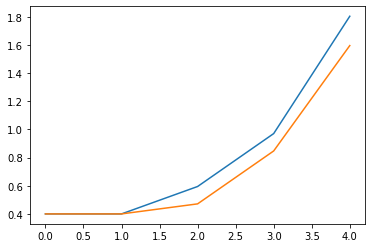

In [235]:
plt.plot(sorted(x_new_samples[0]))
plt.plot(sorted(x_new_samples[10]));

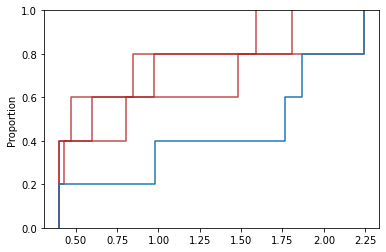

In [237]:
[sns.ecdfplot(i, label='cont-CDF', alpha=0.8, color='firebrick') for i in x_new_samples[:3]]
sns.ecdfplot(x);

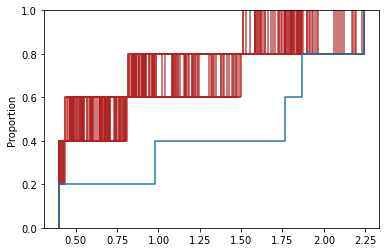

In [239]:
[sns.ecdfplot(i, label='cont-CDF', alpha=0.8, color='firebrick') for i in x_new_samples]
sns.ecdfplot(x);

In [227]:
keys = np.random.randint(0, high = 1000, size=100)
jax_x_new_samples = [jax_cont_resample(sorted_weights, sorted_x, key = keys[i]) for i in range(100)]

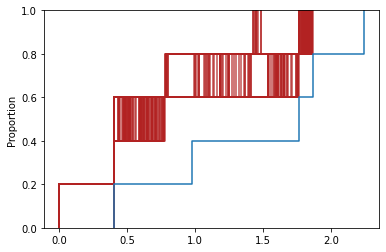

In [228]:
[sns.ecdfplot(i, label='cont-CDF', alpha=0.8, color='firebrick') for i in jax_x_new_samples]
sns.ecdfplot(x);

## Gaussian Copula